# Data Cleaning and Initial Feature Extraction

The useful functions and dictionaries to encoded the data as entered into useful numbers for modeling are in the `housing.py` module which I import along with the rest of the needed Python libraries used in this notebook.

In [1]:
# my module to clean the data and extract features
import housing as hous

# standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# to avoid those vexing warnings on changing behavior coming in pandas
pd.options.mode.copy_on_write = True

In [3]:
df = pd.read_csv('../data/raw/train.csv')

In [4]:
# initial cleaning
housing = hous.data_cleaning(df)

Number of nulls present in data after cleaning: 0


In [5]:
features = housing.drop(columns=['saleprice']).columns.to_list()[2:]

In [6]:
# saving cleaned data for future use (this has been very helpful in speeding up the process)
housing.to_csv('../data/train_auto_clean.csv') 

## Correlations

Let's begin by looking at the numeric features that are most closely correlated with the sale price.

In [7]:
house_no_id = housing.drop(columns=['id', 'pid'])._get_numeric_data()

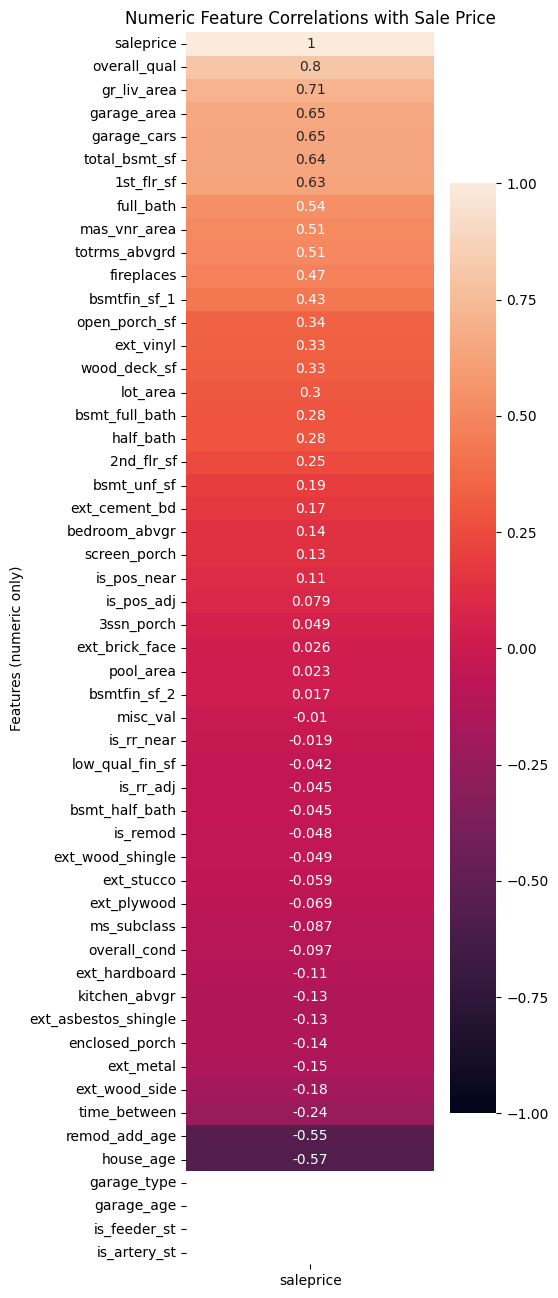

<Figure size 640x480 with 0 Axes>

In [43]:
fig = hous.corr_heatmap(house_no_id);

plt.savefig('../images/correlation_saleprice.jpg')
plt.show();

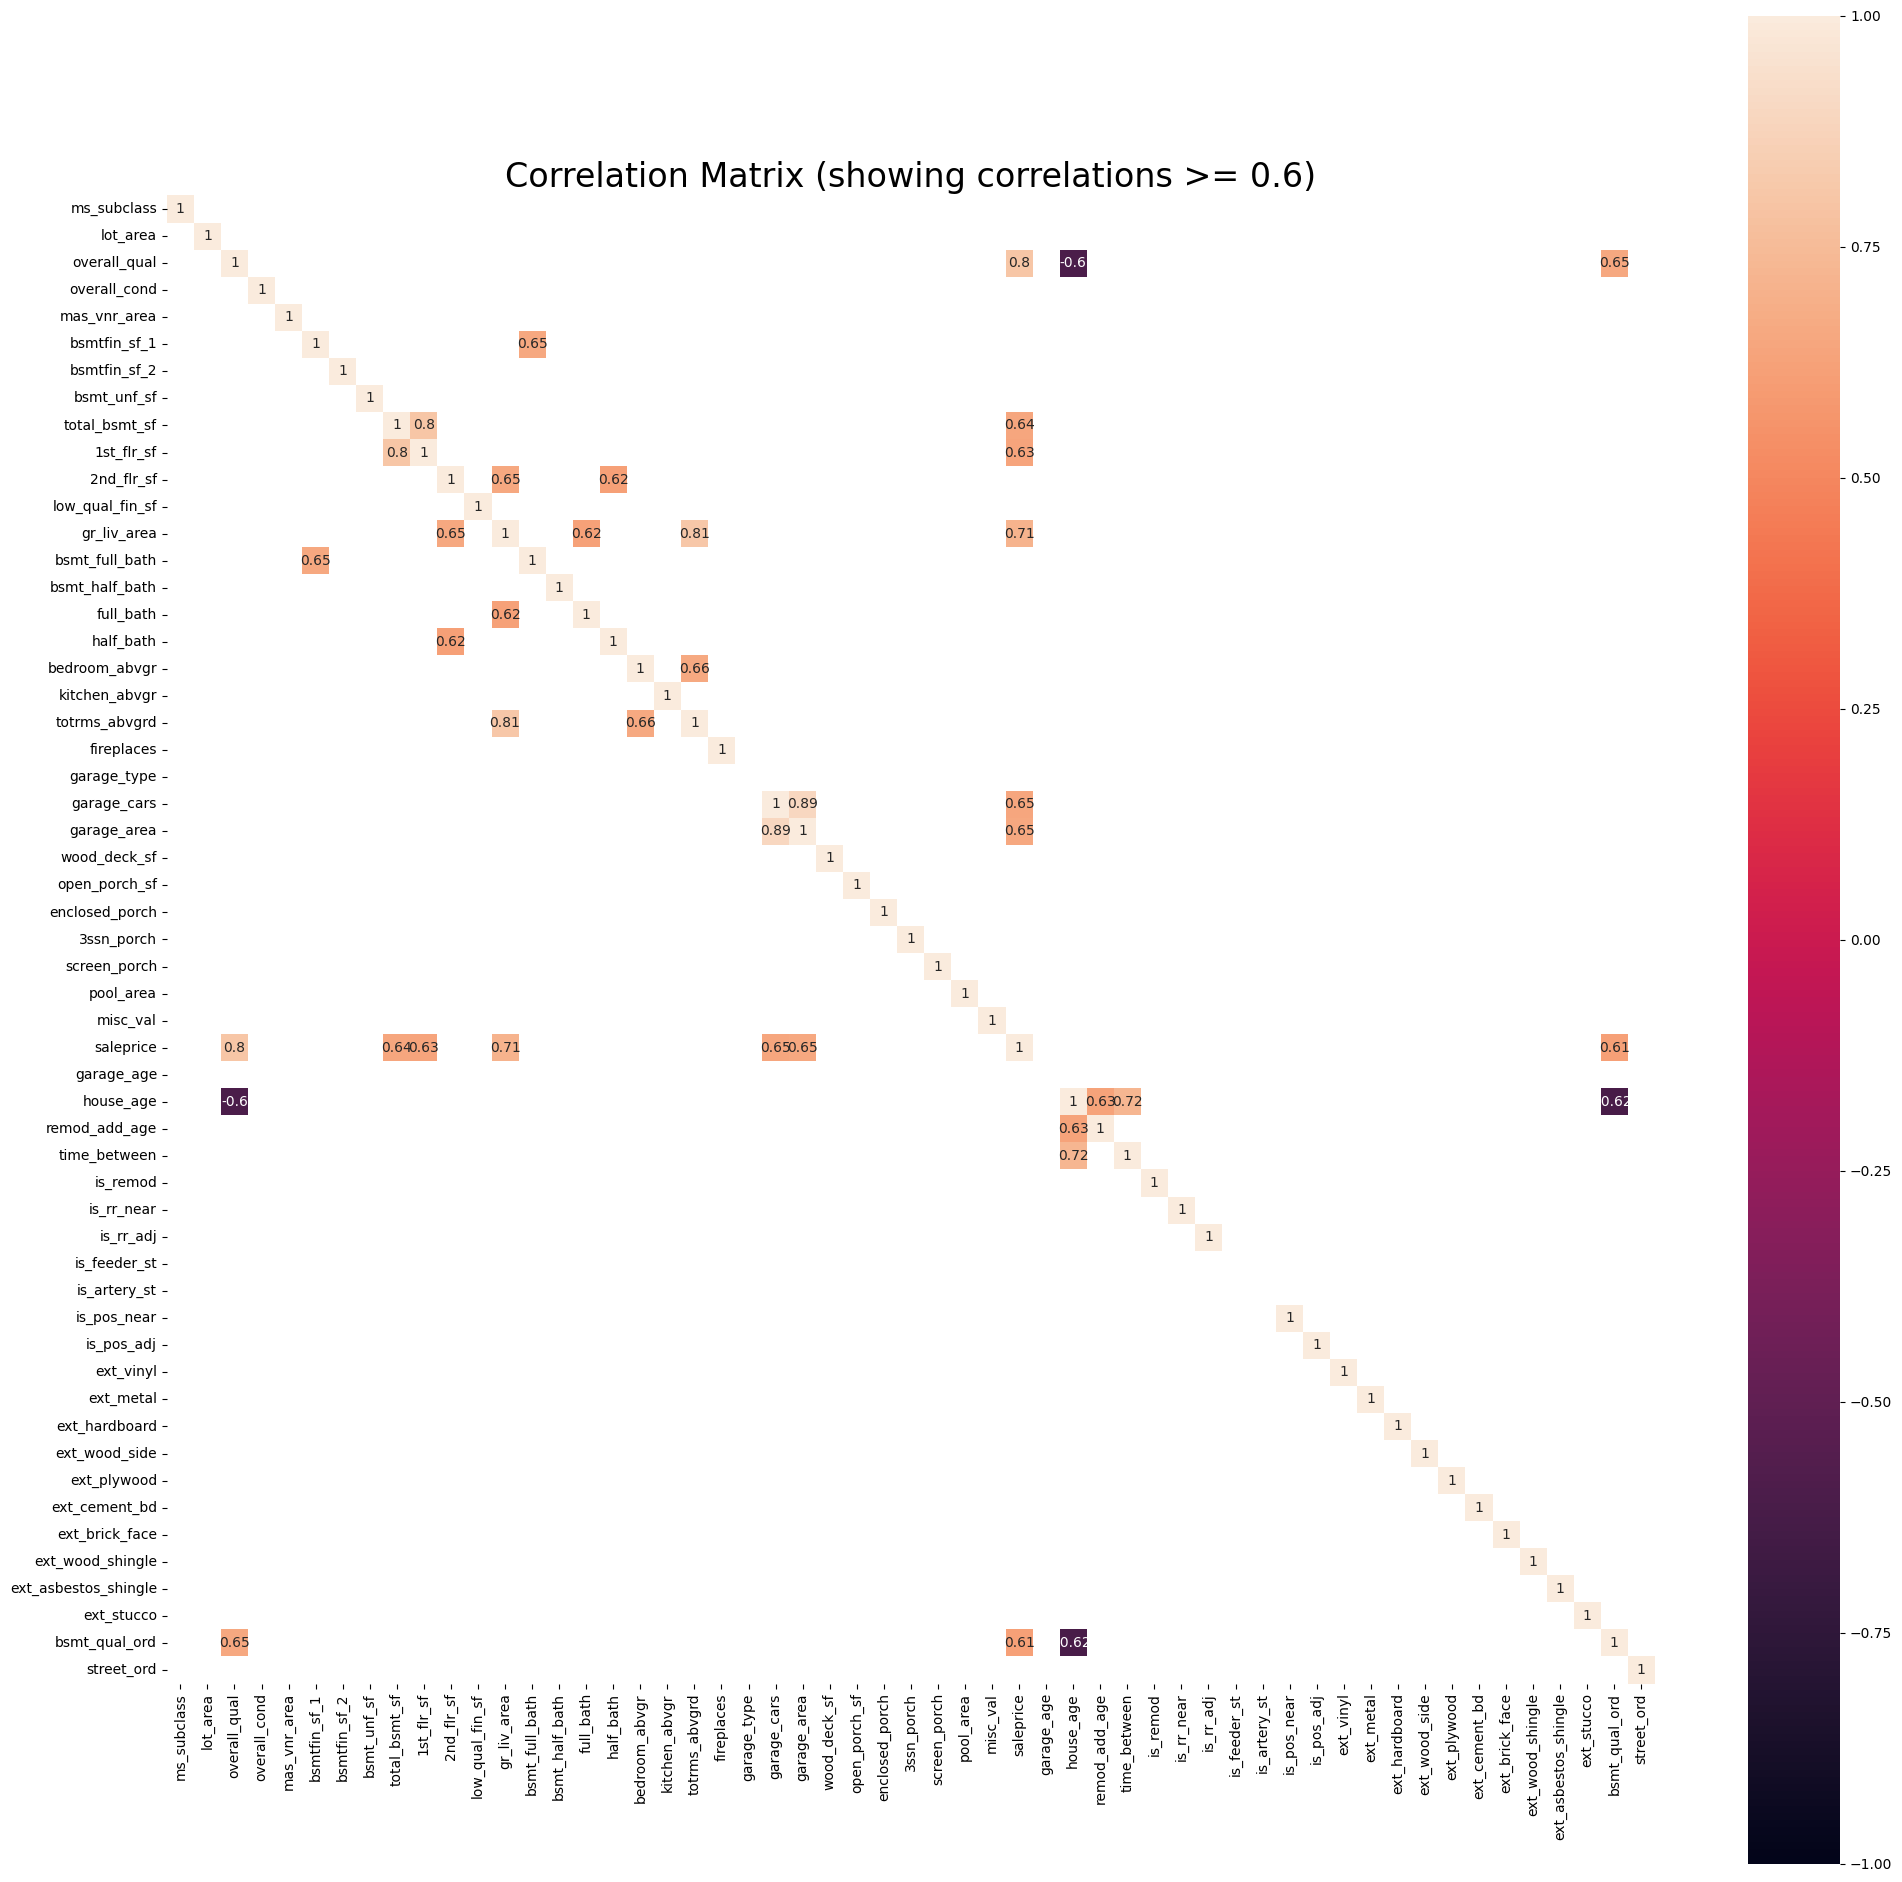

In [44]:
#house_no_id = housing.drop(columns=['id', 'pid'])._get_numeric_data()
corr_mat = housing.drop(columns=['id','pid']).corr(numeric_only=True)

mask = corr_mat.apply(lambda x: abs(x)<0.6)

fig, ax = plt.subplots(figsize=(24,24))

sns.heatmap(corr_mat, mask=mask, vmin=-1, vmax=1, square=True, annot=True)

ax.set_title('Correlation Matrix (showing correlations >= 0.6)', size = 24);

plt.savefig('../images/corr_matrix.jpg')

### Correlated Features

All feature combinations with a correlation absolute value greater than 0.6. These pairs may not be linearly independent.  

| Feature 1 | Feature 2 | Correlation | Notes |
| --- | --- | --- | --- |
| `overall_qual` | `house_age` | $-0.602$ | Newer houses are made of higher quality materials than older houses |
| `bsmtfin_sf_1` | `bsmt_full_bath` | $0.651$ | larger finished basements are more likely to have a full bath |
| `total_bsmt_sf` | `1st_flr_sf` | $0.800$ | the larger the first floor of the house is, the larger it's total basement area is |
| `gr_liv_area` | `totrms_abvgrd` | $0.810$ | the larger the house is, the more total rooms it has |
| `gr_liv_area` | `2nd_flr_sf` | $0.650$ | the larger the house is, the larger the second floor is |
| `gr_liv_area` | `full_bath` | $0.622$ | the larger the house is, the more full bathrooms it has |
| `half_bath` | `2nd_flr_sf` | $0.615$ | the larger the second floor of the house is, the more half baths the house has |
| `bedroom_abvgr` | `totrms_abvgrd` | $0.663$ | as the total number of rooms increases, the number of bedrooms also tends to increase |
|  `garage_cars` | `garage_area` | $0.894$ | the area of the garage is related to how many cars the garage can hold |
| `house_age` | `remod_add_age` | $0.629$ | see note below |

This last combination comes from if the house has *not* been remodel or been added to, then the database lists the year the home was built.

#### `overall_qual` and `house_age`

Not unexpected, modern advanced in material science have resulted in materials that last longer and cost less.  This makes sense to me.  As `overall_qual` is more tightly correlated with the sale price, I will keep that variable.  

As well as a quick acknowledgment that there are some people who really like old homes for some reasons.  Not me, but as long as I don't have to help with the upkeep, then I don't care!

#### `bsmtfin_sf_1` and `bsmt_full_bath`

This also makes sense.  The larger a finished basement is, the more likely it is to have a bathroom.  I will keep the finished basement square footage as finish part of the basement is usually what leads to a bathroom.  

#### `total_bsmt_sf` and `1st_flr_sf`

Every basement, I've ever seen is the same or nearly the same size as the first floor.  These features are collinear.  I will keep the first floor square footage since ever house has a first floor but not every house has a basement.

#### `gr_liv_area` and `totrms_abvgrd`, `2nd_flr_sf`, `full_bath`

The larger the house, the more rooms it has, the larger it's second floor will be and the more bathrooms it will have.  This makes sense as well.  I will keep the living area above ground.  

#### `half_bath` and `2nd_flr_sf`

This is interesting and unexpected.  But then I realized that I was thinking of a half bath as being associated with the first floor.  This is because if a second floor exists, then a half bath is usually built on the first floor.  If the house is a single story, it may not need a half bath at all because the full bath(s) are easily accessible.

#### `bedroom_abvgr` and `totrms_abvgrd`

This makes sense as well.  If there are more rooms, then a house can have more bedrooms.  The total rooms above ground, `totrms-abvgrd` is already collinear with `gr_live_area`, the living area above ground. 

However, when I was selling my house, my real estate agent told me that the total number of bedrooms was more important that the square footage of the house.  Because a buyer usually has a minimum acceptable number of bedrooms that is determined by their family and/or roommate situation.  So the buyer is unlikely to compromise on the minimum needed number of bedrooms.  But they will compromise on the size of those rooms (or other rooms).  

So I'm going to keep the number of bedrooms above ground, `bedroom_abvgr`.

#### `garage_cars` and `garage_area`

This makes lots of sense to me.  Bigger garages hold more cars.  I'm going to keep `garage_area` as buyers will buy for slightly  larger garages if they have a large car or want to extra room for storage or a workshop or something else.

#### `house_age` and `remod_add_age`

This makes sense as well. The older the house, the more time when it could have been remodeled.  I already let `house_age` go, since it's collinear with `overall_qual`.  I'm going to let the time since the most recent remodeling or addition go as well.  These features will be reflected in the overall quality and condition of the house.

## Ordinal Feature Encoding

In [14]:
ord_features = []
for feat in features:
    if hous.feat_class[feat]['type'] == 'ordinal' and hous.feat_class[feat]['encoder'] == 'OrdEncode':
        ord_features.append(feat)

In [15]:
ord_features

['street',
 'lot_shape',
 'utilities',
 'land_slope',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'heating_qc',
 'electrical',
 'kitchen_qual',
 'functional',
 'fireplace_qu',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'pool_qc',
 'fence']

In [16]:
data = housing

In [17]:
for feat in ord_features:
    try:
        data = hous.OrdEncode(data, feat)
    except:
        print(f"{feat} did not encode")
        data = data.drop(columns=[feat])

bsmtfin_type_1 did not encode
bsmtfin_type_2 did not encode
fireplace_qu did not encode
garage_finish did not encode
pool_qc did not encode
fence did not encode


In [18]:
data.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_area', 'alley',
       'land_contour', 'lot_config', 'neighborhood', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'roof_style',
       'roof_matl', 'mas_vnr_type', 'mas_vnr_area', 'foundation',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd',
       'fireplaces', 'garage_type', 'garage_cars', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'pool_area', 'misc_feature', 'misc_val', 'sale_type',
       'saleprice', 'garage_age', 'house_age', 'remod_add_age', 'time_between',
       'is_remod', 'sale_date', 'is_rr_near', 'is_rr_adj', 'is_feeder_st',
       'is_artery_st', 'is_pos_near', 'is_pos_adj', 'ext_vinyl', 'ex

In [19]:
data.to_csv('../data/train_ord_encode.csv', index=False)

## Test Data Transforming

In [20]:
df_test = pd.read_csv('../data/raw/test.csv')

In [21]:
housing_test = hous.data_cleaning(df_test)

Number of nulls present in data after cleaning: 1


### Fixing Remaining Null Values

Let's start by finding the remaining null value.

In [22]:
for col in housing_test.columns:
    num_null= housing_test[col].isnull().sum()
    if num_null > 0:
        print(f"Feature {col} has {num_null} missing entries.")

Feature electrical has 1 missing entries.


The electrical system is missing, that's likely an oversight.  Let's look at the entry.

In [23]:
housing_test[housing_test['electrical'].isnull()==True]

,id,pid,ms_subclass,ms_zoning,lot_area,street,alley,lot_shape,land_contour,utilities,...,ext_vinyl,ext_metal,ext_hardboard,ext_wood_side,ext_plywood,ext_cement_bd,ext_brick_face,ext_wood_shingle,ext_asbestos_shingle,ext_stucco
634,1578,916386080,80,RL,9735,Pave,no,Reg,Lvl,AllPub,...,1,0,0,0,0,0,0,0,0,0


In [24]:
df_test[df_test['Id']==1578]['Year Built']

634    2006
Name: Year Built, dtype: int64

In [25]:
housing_test[housing_test['id']==1578]['utilities']

634    AllPub
Name: utilities, dtype: object

This house was built in 2006 and has all public utilitities (including electrical), what kind of electrical system do houses built during this time have?

In [26]:
df_test[df_test['Year Built']>1990]['Electrical'].value_counts(normalize=True)

Electrical
SBrkr    1.0
Name: proportion, dtype: float64

Every house built after 1990 has the `'SBrkr'` option (means standard circuit breakers and Romex). When was the last house built without this standard option?

In [27]:
df_test[(df_test['Electrical']!='SBrkr') & (df_test['Electrical'].isnull()==False)]['Year Built'].max()

1965

In [28]:
df[(df['Electrical']!='SBrkr') & (df['Electrical'].isnull()==False)]['Year Built'].max()

1960

The oldest homes built without the standard electrical system was 1965 in the test data and 1960 in the train data.  

I'm going to get the electrical column equal to `'SBrkr'` since this was very likely to be an oversight.

In [29]:
housing_test.loc[634,'electrical'] = 'SBrkr'

In [30]:
housing_test.isnull().sum().sum()

0

#### Saving Cleaned Test Data

In [31]:
# save clean test data
housing_test.to_csv('../data/test_cleaned.csv', index=False)

### Encode Ordinals in Test Set

In [32]:
features_test = housing_test.columns.to_list()[2:]

In [33]:
housing_test.to_csv('../data/test_auto_clean.csv') # save cleaned data

In [34]:
data_test = housing_test

In [35]:
for feat in ord_features:
    try:
        data_test = hous.OrdEncode(data_test, feat)
    except:
        print(f"{feat} did not encode")
        data_test = data_test.drop(columns=[feat])

bsmtfin_type_1 did not encode
bsmtfin_type_2 did not encode
fireplace_qu did not encode
garage_finish did not encode
pool_qc did not encode
fence did not encode


In [36]:
data_test.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_area', 'alley',
       'land_contour', 'lot_config', 'neighborhood', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'roof_style',
       'roof_matl', 'mas_vnr_type', 'mas_vnr_area', 'foundation',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd',
       'fireplaces', 'garage_type', 'garage_cars', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'pool_area', 'misc_feature', 'misc_val', 'sale_type',
       'garage_age', 'house_age', 'remod_add_age', 'time_between', 'is_remod',
       'sale_date', 'is_rr_near', 'is_rr_adj', 'is_feeder_st', 'is_artery_st',
       'is_pos_near', 'is_pos_adj', 'ext_vinyl', 'ext_metal', 'ex

In [37]:
data_test.to_csv('../data/test_ord_encode.csv', index=False)

In [38]:
set(data.columns.tolist()).difference(set(data_test.columns.tolist()))

{'saleprice'}

Test and train encoded data sets have the same columns (except the saleprice)

Work continues in `02_eda.ipynb`